In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import gender_guesser.detector as gender
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/Users/jeremyben-meir/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/jeremyben-meir/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
[nltk_data] Downloading package vader_lexicon to /Users/jeremyben-
[nltk_data]     meir/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# DATA CLEANSING

In [2]:
### SALES CSV #############################

try:
    sales = pd.read_pickle("sales.p")
except:
    sales = pd.read_csv("NYC_Citywide_Rolling_Calendar_Sales.csv")
    print(sales.columns)

    sales = sales[~sales['NEIGHBORHOOD'].isna()]
    sales = sales[~sales['TOTAL UNITS'].isna()]
    sales = sales[~sales['LAND SQUARE FEET'].isna()]
    sales = sales[~sales['GROSS SQUARE FEET'].isna()]
    sales = sales[~sales['YEAR BUILT'].isna()]
    sales = sales[~sales['TAX CLASS AT TIME OF SALE'].isna()]
    sales = sales[~sales['BUILDING CLASS AT TIME OF SALE'].isna()]
    sales = sales[sales['TOTAL UNITS']>0]
    sales['SALE PRICE'] = sales['SALE PRICE'].str.replace(",","").astype(int)
    sales = sales[~((sales['SALE PRICE'].isna())|(sales['SALE PRICE']<=0))]
    sales["PRICE/UNIT"] = sales['SALE PRICE']/sales['TOTAL UNITS']
    sales['NEIGHBORHOOD'] = sales['NEIGHBORHOOD'].apply(lambda n: n.replace(" (79-96)","").replace(" (59-79)",""))
    sales.to_pickle("sales.p")
    
### LISTINGS CSV ##########################

try:
    listings = pd.read_pickle("listings.p")
except:
    listings = pd.read_csv("listings.csv")
    print(listings.columns)

    listings['neighbourhood_cleansed'] = listings['neighbourhood_cleansed'].str.upper().str.replace(" DISTRICT","")
    listings["price"] = listings['price'].str.replace("$","").str.replace(",","").astype(float)

    listings = listings[~listings['neighbourhood_cleansed'].isna()]
    listings = listings[~listings['number_of_reviews'].isna()]
    listings = listings[~listings['bedrooms'].isna()]
    listings = listings[~listings['beds'].isna()]
    listings = listings[~listings['host_identity_verified'].isna()]
    listings = listings[~listings['host_has_profile_pic'].isna()]
    listings = listings[~listings['room_type'].isna()]
    listings = listings[~listings['review_scores_rating'].isna()]
    listings = listings[~listings['minimum_nights'].isna()]
    listings = listings[~listings['host_is_superhost'].isna()]
    listings = listings[listings['price']>0]
    listings['host_is_superhost'] = listings['host_is_superhost'].apply(lambda r: 1 if r=="t" else 0)
    listings['host_identity_verified'] = listings['host_identity_verified'].apply(lambda r: 1 if r=="t" else 0)
    listings['host_has_profile_pic'] = listings['host_has_profile_pic'].apply(lambda r: 1 if r=="t" else 0)
    listings.to_pickle("listings.p")
    

# print(sales['NEIGHBORHOOD'].nunique())
# print(listings['neighbourhood_cleansed'].nunique())

# fig, ax = plt.subplots(figsize=(10,6))
# plt.title("Figure 3: Cheapest Neighborhoods by Unit Sale Price")
# plt.ylabel("Sale Price per Unit")
# neighborhood_prices = sales.groupby('NEIGHBORHOOD').agg({'PRICE/UNIT':"mean"}).sort_values("PRICE/UNIT",ascending=False)
# neighborhood_prices['PRICE/UNIT'][-20:].plot.bar()


# Add sentiment to reviews

In [3]:
sia = SentimentIntensityAnalyzer()
reviews = pd.read_csv("reviews.csv")
reviews = reviews[~reviews["comments"].isna()]

try:
    listings_reviews = pd.read_pickle("listings-reviews.p")
except:
    global count
    count = 0
    print(len(reviews["comments"]))

    def add_score(comment):
        try:
            global count
            count+=1
            if count%100000 == 0:
                print(count)
            return sia.polarity_scores(comment)["compound"]
        except:
            print(comment)

    reviews["sentiment"] = reviews["comments"].apply(lambda comment: add_score(comment))

    # merge average sentiment into reviews
    sentiment_df = reviews.groupby("listing_id").agg({"sentiment":"mean"})
    listings_reviews = listings.merge(sentiment_df, how="inner", left_on='id', right_on='listing_id')

    mean_sentiment = listings_reviews["sentiment"].mean()
    listings_reviews['sentiment_binary'] = listings_reviews['sentiment'].apply(lambda s : 1 if s > mean_sentiment else 0)

    listings_reviews.to_pickle("listings-reviews.p")



# Q1

### OPENDATA: neighborhood coef on sale price

In [4]:
X = pd.concat([
        pd.get_dummies(sales['NEIGHBORHOOD'], prefix="neighborhood", drop_first=True),
        sales['TOTAL UNITS'].astype(int),
        sales['LAND SQUARE FEET'].str.replace(",","").astype(int),
        sales['GROSS SQUARE FEET'].astype(int),
        sales['YEAR BUILT'].astype(int),
        pd.get_dummies(sales['TAX CLASS AT TIME OF SALE'], prefix="taxclass", drop_first=True),
        pd.get_dummies(sales['BUILDING CLASS AT TIME OF SALE'], prefix="bldgclass", drop_first=True),
    ],axis=1)

Y = sales['SALE PRICE']**2
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
# print(model.summary())

neighborhood_params = model.params.loc[[val for val in model.params.index if "neighborhood_" in val]]
significant_params = neighborhood_params[neighborhood_params.index.isin(model.pvalues[model.pvalues<=.05].index)]
print(significant_params.sort_values())



/Users/jeremyben-meir/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


neighborhood_FLATIRON                -1.315709e+16
neighborhood_DOWNTOWN-FULTON MALL    -1.095353e+16
neighborhood_MIDTOWN CBD             -4.848817e+15
neighborhood_MIDTOWN EAST            -3.120008e+15
neighborhood_BROOKLYN HEIGHTS         2.982288e+15
neighborhood_SOHO                     4.381627e+15
neighborhood_DOWNTOWN-FULTON FERRY    6.184072e+15
neighborhood_MIDTOWN WEST             1.266708e+16
dtype: float64


/Users/jeremyben-meir/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


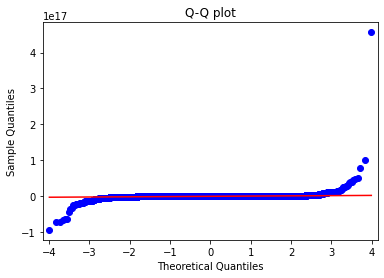

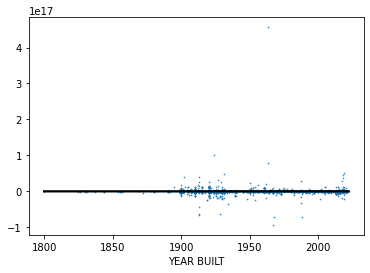

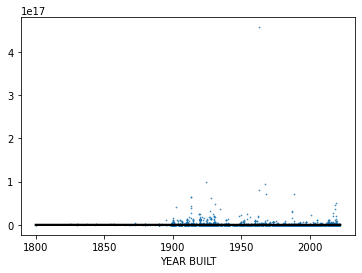

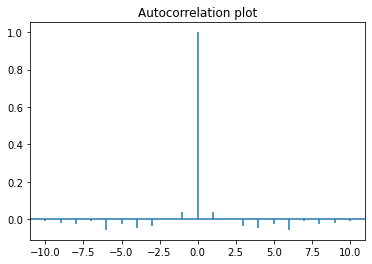

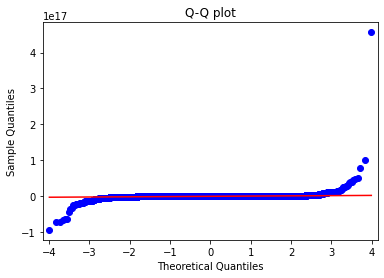

In [5]:
chart1, ax1 = plt.subplots()
chart2, ax2 = plt.subplots()
chart3, ax3 = plt.subplots()
chart4, ax4 = plt.subplots()
ax3.set_title("Autocorrelation plot")
ax4.set_title("Q-Q plot")

x = sales['YEAR BUILT'].astype(int)

sns.regplot(x=x, y=model.resid, lowess=True, line_kws = {'color': 'black'}, scatter_kws = {'s' : 0.5},ax=ax1)
sns.regplot(x=x, y=abs(model.resid), lowess=True, line_kws = {'color': 'black'}, scatter_kws = {'s' : 0.5},ax=ax2)
ax3.acorr(model.resid)
sm.qqplot(model.resid, line="r", ax = ax4)



### AIRBNB: neighborhood coef on nightly price

In [6]:
listings_reviews["beds_bedrooms"] = listings_reviews['beds']*listings_reviews['bedrooms']
listings_reviews["superhost_profile"] = listings_reviews['host_is_superhost']*listings_reviews['host_has_profile_pic']
listings_reviews["superhost_verified"] = listings_reviews['host_is_superhost']*listings_reviews['host_identity_verified']
listings_reviews["profile_verified"] = listings_reviews['host_identity_verified']*listings_reviews['host_has_profile_pic']

X = pd.concat([
        pd.get_dummies(listings_reviews['neighbourhood_cleansed'], prefix="neighborhood", drop_first=True),
        listings_reviews['bedrooms'],
        listings_reviews['beds'],
        listings_reviews['host_is_superhost'],
        listings_reviews['host_has_profile_pic'],
        listings_reviews['host_identity_verified'],
        listings_reviews['review_scores_rating'],
        listings_reviews['minimum_nights'],
        pd.get_dummies(listings_reviews['room_type'], prefix="room_type", drop_first=True),
    
        listings_reviews["beds_bedrooms"],
        listings_reviews["superhost_profile"],
        listings_reviews["superhost_verified"],
        listings_reviews["profile_verified"]
    ],axis=1)

Y = listings_reviews['price']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

neighborhood_params = model.params.loc[[val for val in model.params.index if "neighborhood_" not in val]]
significant_params = neighborhood_params[neighborhood_params.index.isin(model.pvalues[model.pvalues<=.05].index)]
significant_params.sort_values(ascending=False)


/Users/jeremyben-meir/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


bedrooms                  73.139117
beds                      14.823381
minimum_nights            -0.155623
room_type_Private room   -48.084026
dtype: float64

# Q2: Get compound sentiment of each review

In [7]:
from sklearn.metrics import f1_score,recall_score
d = gender.Detector()
mean_sentiment = listings_reviews["sentiment"].mean()
listings_reviews['sentiment_binary'] = listings_reviews['sentiment'].apply(lambda s : 1 if s > mean_sentiment else 0)
listings_reviews['sq_beds'] = listings_reviews['beds']**2
listings_reviews['sq_bedrooms'] = listings_reviews['bedrooms']**2
listings_reviews["gender"] = listings_reviews["host_name"].apply(lambda x : d.get_gender(x))

X = pd.concat([
    listings_reviews['bedrooms'],
    listings_reviews['sq_bedrooms'],
    listings_reviews['beds'],
    listings_reviews['sq_beds'],
    pd.get_dummies(listings_reviews['host_is_superhost'], prefix="host_is_superhost", drop_first=True),
    pd.get_dummies(listings_reviews['host_has_profile_pic'], prefix="host_has_profile_pic", drop_first=True),
    pd.get_dummies(listings_reviews['host_identity_verified'], prefix="host_identity_verified", drop_first=True),
    pd.get_dummies(listings_reviews['room_type'], prefix="room_type", drop_first=True),
    pd.get_dummies(listings_reviews['gender'], prefix="gender", drop_first=True),


    listings_reviews["beds_bedrooms"],
    listings_reviews["superhost_profile"],
    listings_reviews["superhost_verified"],
    listings_reviews["profile_verified"]
],axis=1)

Y = listings_reviews['sentiment_binary']
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

model = sm.Logit(y_train, X_train).fit()
model.summary()

predicted = model.predict(X_test)
predicted[predicted>.5] = 1
predicted[predicted<1] = 0

confusion_matrix(y_test, predicted)
print(f1_score(y_test, predicted))
print(recall_score(y_test, predicted))

# significant_params = model.params.loc[model.params.index.isin(model.pvalues[model.pvalues<=.05].index)]
# significant_params

Optimization terminated successfully.
         Current function value: 0.628588
         Iterations 6
0.7555296856810245
0.8698066245452805


/Users/jeremyben-meir/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


# Q3: Random Variables

In [8]:
reviews_summary = listings_reviews["review_scores_rating"].describe()
sentiment_summary = listings_reviews["sentiment"].describe()
print(reviews_summary)
print(sentiment_summary)

count    25147.000000
mean         4.612306
std          0.783162
min          0.000000
25%          4.600000
50%          4.830000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64
count    25147.000000
mean         0.716129
std          0.239857
min         -0.998800
25%          0.646336
50%          0.768033
75%          0.865819
max          0.998700
Name: sentiment, dtype: float64


In [9]:
N=10000
# random_reviews = np.random.normal(reviews_summary["mean"],reviews_summary["std"],N)
# random_sentiment = np.random.normal(sentiment_summary["mean"],sentiment_summary["std"],N)
# random_sentiment = random_sentiment[(random_sentiment<=1)|(random_sentiment>=-1)]
# print(random_reviews)
# print(random_sentiment)

random_sentiment = np.random.uniform(-1,1,N)
random_bedrooms = np.random.uniform(0,7,N)
random_cleanliness = np.random.uniform(0,5,N)
random_checkin = np.random.uniform(0,5,N)
random_communication = np.random.uniform(0,5,N)
random_location = np.random.uniform(0,5,N)
random_accuracy = np.random.uniform(0,5,N)






<AxesSubplot:>

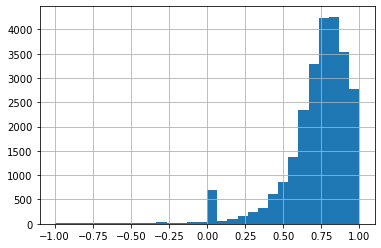

In [10]:
# listings_reviews["review_scores_rating"].hist(bins=30)
listings_reviews["sentiment"].hist(bins=30)


(-1.0, 1.0)

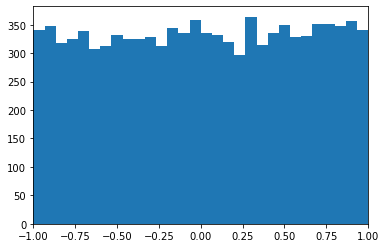

In [11]:
plt.hist(random_sentiment,bins=30)
plt.xlim(-1,1)

In [17]:
scores = ["sentiment","bedrooms","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_accuracy"]

for score in scores:
    listings_reviews = listings_reviews[~listings_reviews[score].isna()]
    listings_reviews["sq_"+score] = listings_reviews[score]**2

neighborhood_sentiment = pd.get_dummies(listings_reviews['neighbourhood_cleansed'], prefix="neighborhood_sentiment", drop_first=True).astype(float)
print(listings_reviews["sentiment"])
print(neighborhood_sentiment)
neighborhood_sentiment = neighborhood_sentiment.mul(listings_reviews["sentiment"],axis=1)
print(neighborhood_sentiment)
    
# X_Q3 = pd.concat([
#     pd.get_dummies(listings_reviews['neighbourhood_cleansed'], prefix="neighborhood", drop_first=True),
#     listings_reviews['number_of_reviews'],
#     listings_reviews['beds'],
#     pd.get_dummies(listings_reviews['host_is_superhost'], prefix="host_is_superhost", drop_first=True),
#     pd.get_dummies(listings_reviews['host_has_profile_pic'], prefix="host_has_profile_pic", drop_first=True),
#     pd.get_dummies(listings_reviews['host_identity_verified'], prefix="host_identity_verified", drop_first=True),
#     pd.get_dummies(listings_reviews['room_type'], prefix="room_type"),
#     listings_reviews['minimum_nights'],
    
    
#     listings_reviews["sentiment"],
#     listings_reviews['review_scores_cleanliness'],
#     listings_reviews['review_scores_checkin'],
#     listings_reviews['review_scores_communication'],
#     listings_reviews['review_scores_location'],
#     listings_reviews['review_scores_accuracy'],
#     listings_reviews["sq_sentiment"],
#     listings_reviews['sq_review_scores_cleanliness'],
#     listings_reviews['sq_review_scores_checkin'],
#     listings_reviews['sq_review_scores_communication'],
#     listings_reviews['sq_review_scores_location'],
#     listings_reviews['sq_review_scores_accuracy'],
#     neighborhood_sentiment,
    
# ],axis=1)

# Y_Q3 = listings_reviews['price']
# X_Q3 = sm.add_constant(X_Q3)
# model_Q3 = sm.OLS(Y_Q3, X_Q3).fit()
# model_Q3.summary()


0        0.863958
1        0.989900
2        0.578484
3        0.938482
4        0.844276
           ...   
25142    0.896000
25143    0.988900
25144    0.988900
25145    0.964400
25146    0.925900
Name: sentiment, Length: 24689, dtype: float64
       neighborhood_sentiment_ARDEN HEIGHTS  neighborhood_sentiment_ARROCHAR  \
0                                       0.0                              0.0   
1                                       0.0                              0.0   
2                                       0.0                              0.0   
3                                       0.0                              0.0   
4                                       0.0                              0.0   
...                                     ...                              ...   
25142                                   0.0                              0.0   
25143                                   0.0                              0.0   
25144                              

       neighborhood_sentiment_ARDEN HEIGHTS  neighborhood_sentiment_ARROCHAR  \
0                                       NaN                              NaN   
1                                       NaN                              NaN   
2                                       NaN                              NaN   
3                                       NaN                              NaN   
4                                       NaN                              NaN   
...                                     ...                              ...   
25142                                   NaN                              NaN   
25143                                   NaN                              NaN   
25144                                   NaN                              NaN   
25145                                   NaN                              NaN   
25146                                   NaN                              NaN   

       neighborhood_sentiment_ARVERNE  

In [ ]:
print(len(model_Q3.params))

In [ ]:
neighborhood = "FLATIRON"
neighborhood_index = list(model_Q3.params.index).index("neighborhood_"+neighborhood)
print(neighborhood_index)

In [ ]:
print(list(model_Q3.params.index)[220:])

In [ ]:
feature_vector = [0]*220
feature_vector[neighborhood_index] = 1 #flatiron location so 1
feature_vector[0] = 1 #constant 
avg_num_reviews = listings_reviews["number_of_reviews"].mean()
bedrooms = 1 # max is 15 which is way to high 
beds = 1
avg_minimum_nights = int(listings_reviews["minimum_nights"].mean())
# listings_reviews[""]
# listings_reviews[""]
# listings_reviews[""]
# listings_reviews[""]

non_neighborhood_features = [avg_num_reviews, beds, 1,1,1,1,0,0,0, avg_minimum_nights]
main_feature_vector = feature_vector + non_neighborhood_features
len(main_feature_vector)

In [ ]:
import statistics
yhat_price_list = []
for i in range(len(random_reviews)):
    final_features = main_feature_vector + [random_sentiment[i],random_cleanliness[i], random_checkin[i], random_communication[i], random_location[i], random_accuracy[i],random_sentiment[i]**2,random_cleanliness[i]**2, random_checkin[i]**2, random_communication[i]**2, random_location[i]**2, random_accuracy[i]**2]
    y = model_Q3.predict(final_features)[0]
    yhat_price_list.append(y)

print(statistics.mean(yhat_price_list))


  

In [ ]:
plt.hist(yhat_price_list,bins=30)

In [ ]:
print(min(yhat_price_list))
print(max(yhat_price_list))
print(max(yhat_price_list)-min(yhat_price_list))

In [ ]:
print(max(yhat_price_list))

In [ ]:
listings_reviews

print(listings_reviews[listings_reviews['neighbourhood_cleansed'] == neighborhood]['price'].mean())
print(listings_reviews[listings_reviews['neighbourhood_cleansed'] == neighborhood]['beds'].mean())